# POC show Ibis CLL within Kedro pipeline DAG


- Ibis is an exciting pythonic project which allows users to use multiple execution back-ends with the same syntax
 - It's potentially the answer to the long standing 'how do we use SQL well in Kedro' question
 - It's potentially the answer to allowing users to use a different execution engine in Prod vs Dev ([slack thread](https://linen-slack.kedro.org/t/16627336/i-want-to-use-pyspark-my-databricks-environment-but-polars-l#19fb7cae-5909-4dab-984c-a4d2d47fbbc3))
 - [dbt](https://docs.getdbt.com/docs/collaborate/column-level-lineage) released CLL as a paid feature recently, potentially this is an opportunity to make an adoption push with a feature people are willing to pay for.

In [1]:
from kedro.runner.sequential_runner import SequentialRunner
from kedro.io.data_catalog import DataCatalog
from jaffle_shop.utilities.graph import (
    kedro_node_ibis_plan, 
    kedro_pipeline_to_graph, 
    nx_graph_to_pyvis,
    get_lineage_for_kedro_node
)

Retrieve pipelines object (automatically in scope via `kedro jupyter notebook`)

In [2]:
default_pipeline = pipelines['__default__']
default_pipeline


Pipeline([
Node(rename_customers, 'raw_customers', 'stg_customers', None),
Node(rename_orders, 'raw_orders', 'stg_orders', None),
Node(rename_payments, 'raw_payments', 'stg_payments', None),
Node(process_customers, ['stg_customers', 'stg_orders', 'stg_payments'], 'customers', None),
Node(process_orders, ['stg_orders', 'stg_payments', 'params:payment_methods'], ['orders', 'temp_orders'], None)
])

## Render Kedro Pipeline (equivilent to Kedro-Viz)

In [3]:
nx_pipeline_graph = kedro_pipeline_to_graph(default_pipeline, catalog)
print(nx_pipeline_graph, type(nx_pipeline_graph))
nx_graph_to_pyvis(nx_pipeline_graph).show('kedro_pipeline.html')

DiGraph with 15 nodes and 15 edges <class 'networkx.classes.digraph.DiGraph'>
kedro_pipeline.html


<IPython.lib.display.IFrame object at 0x16b7dfeb0>

## Retrieve Kedro Node

In [8]:
n = default_pipeline.nodes[1]
n

Node(rename_orders, 'raw_orders', 'stg_orders', None)

In [9]:
import inspect
print(inspect.getsource(n.func))

def rename_orders(source: ir.Table) -> ir.Table:
    renamed = source[
        source.id.name("order_id"),
        source.user_id.name("customer_id"),
        "order_date",
        "status",
    ]
    return renamed



## Run node with zero data

In [21]:
import ibis
n.run(
    {'raw_orders': ibis.memtable(
            {
                'id':[], 
                "user_id": [], 
                "order_date": [], 
                "status": []
            }
        )
    }
)

[02/28/24 10:22:53] INFO     Running node: rename_orders([raw_orders]) -> [stg_orders]                  ]8;id=262112;file:///Users/joel_schwarzmann/anaconda3/envs/jaffle-lineage/lib/python3.10/site-packages/kedro/pipeline/node.py\node.py]8;;\:]8;id=127688;file:///Users/joel_schwarzmann/anaconda3/envs/jaffle-lineage/lib/python3.10/site-packages/kedro/pipeline/node.py#340\340]8;;\


{
    'stg_orders': r0 := InMemoryTable
  data:
    PandasDataFrameProxy:
      Empty DataFrame
      Columns: [id, user_id, order_date, status]
      Index: []

Selection[r0]
  selections:
    order_id:    r0.id
    customer_id: r0.user_id
    order_date:  r0.order_date
    status:      r0.status
}

## What is a query plan?

- Ibis is a pythonic, lazily evaluated library which creates a query plan of how a job will be done without actually doing the work!
- Much like Spark, below we want to work with the `optimized logical plan`
- Pandas famously doesn't have a query plan, you as the human are the query planner

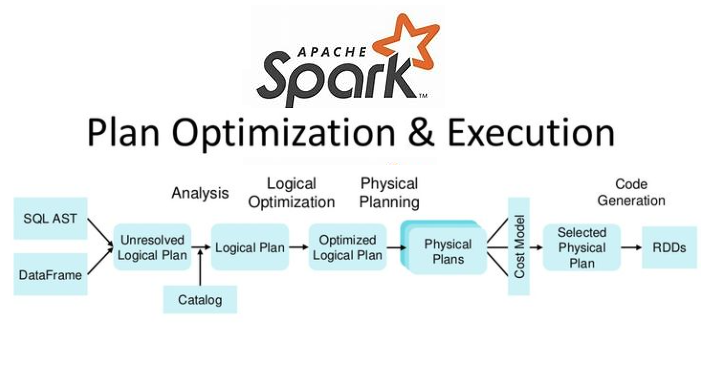

## Show Ibis CLL within Kedro node

> Change to node[4] to show a complex operation

In [10]:
nx_node_graph = kedro_node_ibis_plan(n,catalog)
nx_graph_to_pyvis(nx_node_graph).show('../data/03_primary/kedro_node.html')

../data/03_primary/kedro_node.html


<IPython.lib.display.IFrame object at 0x17584bbe0>

## Combine Ibis CLL with wider Kedro DAG

In [12]:
nx_graph_to_pyvis(
    get_lineage_for_kedro_node(
        default_pipeline,
        default_pipeline.nodes[1],
        catalog
    )
).show('graph.html')

graph.html


<IPython.lib.display.IFrame object at 0x175874520>